# Tutorial #4: Multilayer Perceptrons

Multilayer perceptrons (MLPs), also known as feedforward neural networks, apply a series of linear transformations followed by non-linear activation functions. At each layer in an MLP, the hidden units (neurons) $\boldsymbol{h}$ are given by $$\boldsymbol{h} = g(\boldsymbol{W} \boldsymbol{x} + \boldsymbol{b})$$ where $\boldsymbol{x}$ is the input from the previous hidden layer and $g$ is a non-linear function. MLPs can be used either in regression, where the output layer is linear layer, or in classification, where the output layer is a softmax. 

A good resource on MLPs is Chapter 6 of the [Deep Learning Book](https://www.deeplearningbook.org/).

We'll start by replacing the linear regression model on the synthetic dataset from tutorial #1 with an MLP. We'll then train an MLP to perform classification on the MNIST dataset of handwritten digits. 

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
import jax.random as random
from flax import nnx
import flax
import optax

### 3.1: MLP for 1D regression on a synthetic dataset

We'll begin by recreating the data used in tutorial #1.

In [2]:
def ground_truth(x):
    return 3*x - 0.2*x**2 - 0.05 * x**3

def generate_data(key, N_data, L, sigma=1.0):
    key1, key2 = random.split(key)
    x = random.uniform(key1,(N_data,)) * L
    y = ground_truth(x) + sigma * random.normal(key2, (N_data,))
    return x, y

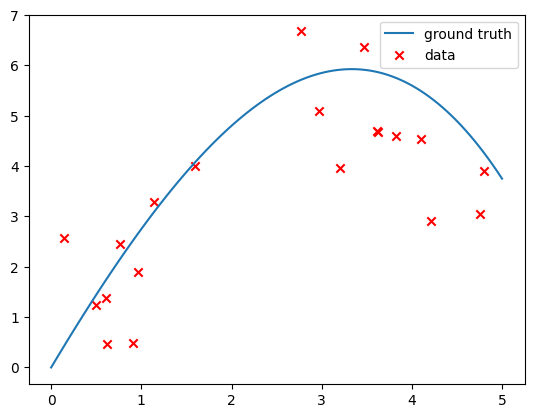

In [3]:
# plot ground truth and data

L = 5 # domain is from 0 to 5
N_data = 20
N_plot = 100
x_plot = jnp.linspace(0,L,N_plot)

key = random.PRNGKey(0)
x_data, y_data = generate_data(key, N_data=N_data, L=L)

plt.plot(x_plot, ground_truth(x_plot), label='ground truth')
plt.scatter(x_data, y_data, color='red', marker='x', label='data')
plt.legend()
plt.show()

We'll create an MLP with one input variable $x$, three hidden layers with five hidden units each, ReLU activation functions, and one output variable $y$.

In [4]:
class scalarMLP(nnx.Module):
    def __init__(self, dhiddens: list[int], rngs: nnx.Rngs):
        self.linear_in = nnx.Linear(1, dhiddens[0], rngs=rngs)
        self.layers = []
        for j in range(len(dhiddens)-1):
            self.layers.append(nnx.Linear(dhiddens[j], dhiddens[j+1], rngs=rngs))
        self.linear_out = nnx.Linear(dhiddens[-1], 1, rngs=rngs)

    def __call__(self, x):
        x = nnx.relu(self.linear_in(x))
        for layer in self.layers:
            x = nnx.relu(layer(x))
        return self.linear_out(x)[..., 0]

In [5]:
rngs = nnx.Rngs(0)
model = scalarMLP([5, 5, 5], rngs)
optimizer = nnx.Optimizer(model, optax.adam(1e-3))
nnx.display(model)

scalarMLP(
  linear_in=Linear(
    kernel=Param(
      value=Array(shape=(1, 5), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(5,), dtype=float32)
    ),
    in_features=1,
    out_features=5,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x117ce3ba0>,
    bias_init=<function zeros at 0x1151f1ee0>,
    dot_general=<function dot_general at 0x114a37d80>
  ),
  layers=[Linear(
    kernel=Param(
      value=Array(shape=(5, 5), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(5,), dtype=float32)
    ),
    in_features=5,
    out_features=5,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x117ce3ba0>,
    bias_init=<function zeros at 0x1151f1ee0>,
    dot_general=<function dot_general at 0x114a37d80>
  ), Linear(
    kernel=Param(
      v

In [6]:
@nnx.jit
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        y_pred = model(x)
        return jnp.mean((y - y_pred)**2)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)

    return loss

In [7]:
X = x_data.reshape(N_data, 1)
Y = y_data.reshape(N_data)

try:
    loss = train_step(model, optimizer, X, y_data)
    print(loss)
except:
    print("shape of x_data and y_data incorrect")

17.902227


In [8]:
N_train = 20000
losses = []
for _ in range(N_train):
    loss = train_step(model, optimizer, X, Y)
    losses.append(loss)

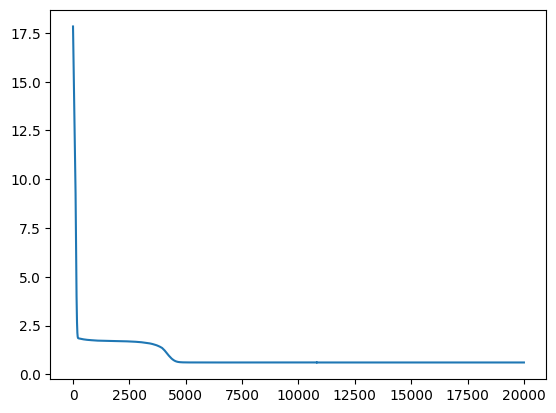

In [9]:
plt.plot(losses)
plt.show()

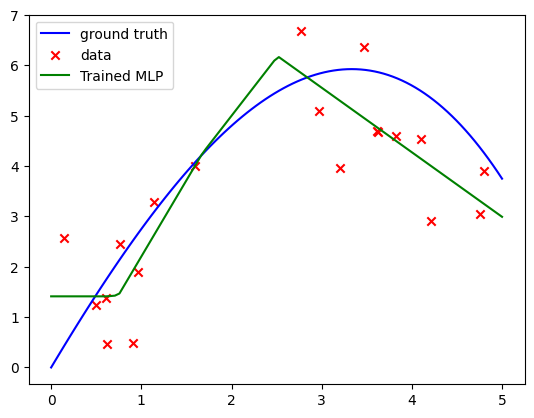

In [10]:
plt.plot(x_plot, ground_truth(x_plot), color='blue', label='ground truth')
plt.scatter(x_data, y_data, color='red', marker='x', label='data')
plt.plot(x_plot, model(x_plot.reshape(N_plot,1)), color='green', label='Trained MLP')
plt.legend()
plt.show()

#### 3.1.1: Varying the complexity of MLPs

We saw that our MLP with three hidden layers and five hidden units gives a piecewise linear function. What happens as we change the number of hidden units and number of layers?

In [11]:
N_train = 20000
rngs = nnx.Rngs(0)
hdims_list = [[3,3],[5,5,5],[7,7,7,7],[9,9,9,9,9]]
models = []
optimizers = []

for hdims in hdims_list:
    model = scalarMLP(hdims, rngs)
    models.append(model)
    optimizers.append(nnx.Optimizer(model, optax.adam(1e-3)))

for j, model in enumerate(models):
    optimizer = optimizers[j]
    print(j)
    for _ in range(N_train):
        loss = train_step(model, optimizer, X, Y)

0
1
2
3


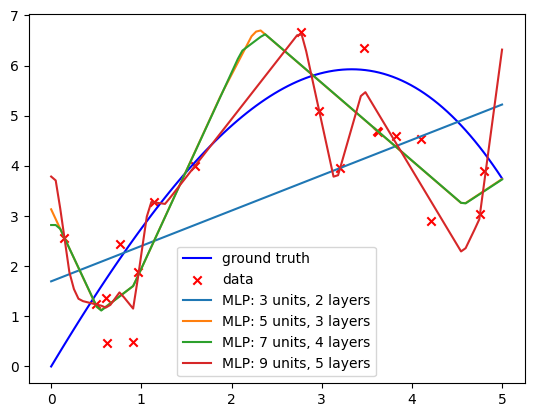

In [12]:
labels = []
for hdims in hdims_list:
    labels.append("MLP: {} units, {} layers".format(hdims[0], len(hdims)))

plt.plot(x_plot, ground_truth(x_plot), color='blue', label='ground truth')
plt.scatter(x_data, y_data, color='red', marker='x', label='data')
for j, model in enumerate(models):
    plt.plot(x_plot, model(x_plot.reshape(N_plot,1)), label=labels[j])
plt.legend()
plt.show()

As we can see, the deeper networks with more hidden units result in more complex functions than the smaller networks. The MLP with 3 hidden units and 2 layers simply results in a linear model.

### 3.2: MLP for MNIST

This part of the tutorial is heavily influenced by the `flax` [MNIST tutorial](https://flax.readthedocs.io/en/latest/mnist_tutorial.html), in which a convolutional neural network is trained using MNIST.

#### 3.2.1: Load MNIST dataset

First we need to load the MNIST dataset. We'll use `tfds` and prepare the dataset for `num_epochs` training epochs with a batch size of 32.

In [13]:
import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.
import matplotlib.pyplot as plt
tf.random.set_seed(0)  # Set the random seed for reproducibility.

train_ds: tf.data.Dataset = tfds.load('mnist', split='train', data_dir='datasets/tensorflow_datasets')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test', data_dir='datasets/tensorflow_datasets')

# normalize train set
train_ds = train_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
) 
# Normalize test set
test_ds = test_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)

We'll use a batch size of 32, and train for 5 epochs.

In [14]:
batch_size = 32
num_epochs = 5
buffer_size = 1024
lr = 1e-3
momentum = 0.9

In [15]:
train_ds_iterator = train_ds.shuffle(buffer_size = buffer_size).batch(batch_size, drop_remainder=True).repeat(num_epochs).prefetch(1)
test_ds_iterator = test_ds.batch(batch_size, drop_remainder = True)

#### 3.2.2: Create MLP in `flax`

Next we'll create our MLP model and our optimizer. 

In [16]:
class MNIST_MLP(nnx.Module):
    def __init__(self, din: int, dhiddens: list[int], dout: int, rngs: nnx.Rngs):
        self.linear_in = nnx.Linear(din, dhiddens[0], rngs=rngs)
        self.layers = []
        for j in range(len(dhiddens)-1):
            self.layers.append(nnx.Linear(dhiddens[j], dhiddens[j+1], rngs=rngs))
        self.linear_out = nnx.Linear(dhiddens[-1], dout, rngs=rngs)

    def __call__(self, x):
        x = x.reshape(x.shape[0], -1)
        x = nnx.relu(self.linear_in(x))
        for layer in self.layers:
            x = nnx.relu(layer(x))
        return self.linear_out(x)

In [17]:
for sample in train_ds.take(1):
    MNIST_image = jnp.asarray(sample['image'])
    MNIST_output = sample['label']
MNIST_image_dims = MNIST_image.shape
print(MNIST_image_dims)
print(MNIST_image.flatten().shape[0])
print(MNIST_output)

(28, 28, 1)
784
tf.Tensor(4, shape=(), dtype=int64)


2025-06-16 15:28:41.854304: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [18]:
rngs = nnx.Rngs(0)
model = MNIST_MLP(MNIST_image.flatten().shape[0], [64, 64, 64], 10, rngs)
optimizer = nnx.Optimizer(model, optax.adamw(lr, momentum))
nnx.display(model)

MNIST_MLP(
  linear_in=Linear(
    kernel=Param(
      value=Array(shape=(784, 64), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    in_features=784,
    out_features=64,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x117ce3ba0>,
    bias_init=<function zeros at 0x1151f1ee0>,
    dot_general=<function dot_general at 0x114a37d80>
  ),
  layers=[Linear(
    kernel=Param(
      value=Array(shape=(64, 64), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    in_features=64,
    out_features=64,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x117ce3ba0>,
    bias_init=<function zeros at 0x1151f1ee0>,
    dot_general=<function dot_general at 0x114a37d80>
  ), Linear(
    kernel=Pa

We can calculate the number of parameters of our MLP model as follows.

In [19]:
graphdef, params = nnx.split(model, nnx.Param)
print(sum(x.size for x in jax.tree_leaves(params)))

59210


/var/folders/tc/jbxr7_990xz0q7yz7p9gvtjh0000gp/T/ipykernel_74449/3525389127.py:2: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree.leaves (jax v0.4.25 or newer) or jax.tree_util.tree_leaves (any JAX version).
  print(sum(x.size for x in jax.tree_leaves(params)))


Now we'll test our model on one sample from the training dataset.

In [20]:
print(model(MNIST_image.reshape(-1)[None, ...]))

[[ 0.13743071  0.12718168  0.1726518   0.13360526  0.01652289 -0.10974506
  -0.02606095 -0.00965687  0.05571373 -0.09061265]]


#### 3.2.3: Write train and eval steps

Before we train our model, we'll set up some functions with which to track the performance of the MLP. We'll want to measure the loss and accuracy on both the training set and the testing set. To do this, we'll introduce a `nnx.MultiMetric` object.

In [21]:
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

We'll introduce a loss function and a `train_step` function, as usual. We could have converted our `batch['label']` into a one-hot encoding and used `optax.softmax_cross_entropy`, but instead we'll use `optax.softmax_cross_entropy_with_integer_labels`. We'll output both the classification logits and the loss value, because the logits will be useful in computing accuracy statistics.

In [22]:
def loss_fn(model: MNIST_MLP, batch):
    logits = model(batch['image'])
    loss = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits, batch['label']))
    return loss, logits

@nnx.jit
def train_step(model: MNIST_MLP, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux = True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss = loss, logits=logits, labels=batch['label'])
    optimizer.update(grads)

The only difference in the `train_step` between the MLP we wrote in 3.1 and the MNIST_MLP we are writing here is in the `metrics.update` function, which computes the average value of the loss and the accuracy. The `nnx.MultiMetric` objects knows how to calculate the accuracy from the logits and the labels.

We'll also write an `eval_step`, which we'll use to compute metrics on the test set over time.

In [23]:
@nnx.jit
def eval_step(model: MNIST_MLP, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.

#### 3.2.4: Train MLP

In [24]:
from IPython.display import clear_output
eval_every = 200

metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

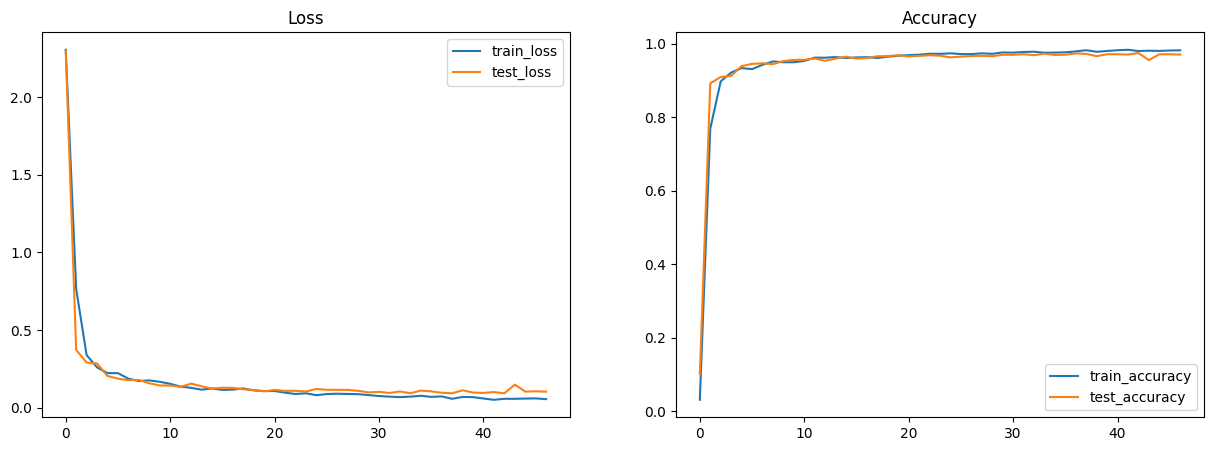

In [25]:
for step, batch in enumerate(train_ds_iterator.as_numpy_iterator()):
    train_step(model, optimizer, metrics, batch)
    
    if step % eval_every == 0:

        # log training metrics to history
        for metric, value in metrics.compute().items():
            metrics_history[f'train_{metric}'].append(value)

        # reset the metrics between each eval_every number of batches
        # also to compute metrics on the test set
        metrics.reset() 

        # not necessary for training, but necessary for evaluating model on test set if dropout and/or batchnorm are used
        model.eval()

        # loop through test set to compute metrics
        for test_batch in test_ds_iterator.as_numpy_iterator():
            eval_step(model, metrics, test_batch)

        # log testing metrics to history
        for metric, value in metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        # reset metrics for next set of training runs
        metrics.reset()

        # not necessary here since dropout and/or batchnorm aren't used, but reverts to train mode
        model.train()

        # plot metrics over time
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        for dataset in ('train', 'test'):
          ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
          ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
        ax1.legend()
        ax2.legend()
        plt.show()
        

#### 3.2.5: Evaluate MLP on Test Set

We'll first print the accuracy on the testing set. Then we'll compare our predictions to the images to visually confirm that our model gives accurate results.

In [26]:
# clear metrics
metrics.reset()

# set model to eval mode, which is unnecessary for our MLP but is required when dropout and batchnorm are used (see tutorial 6)
model.eval()

for test_batch in test_ds_iterator.as_numpy_iterator():
    eval_step(model, metrics, test_batch)

print(metrics.compute()['accuracy'])

0.97155446


We get an accuracy of 97% on the testing dataset.

In [27]:
@nnx.jit
def pred_step(model: MNIST_MLP, batch):
    logits = model(batch['image'])
    return logits.argmax(axis=1)

In [28]:
test_ds_iterator = test_ds.batch(25).as_numpy_iterator()

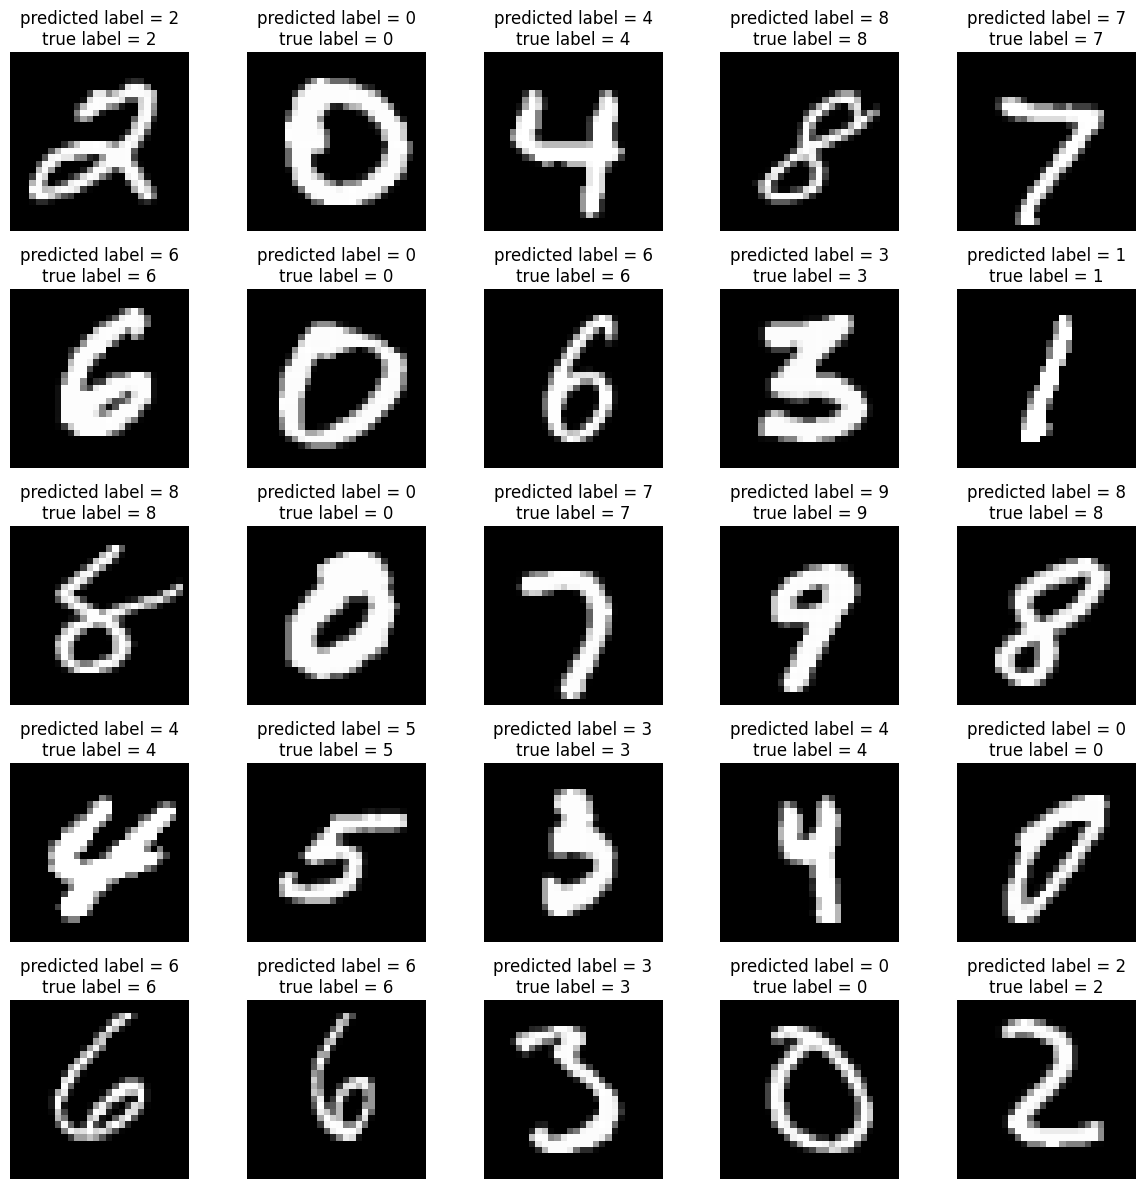

In [29]:
test_batch = test_ds_iterator.next()

preds = pred_step(model, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i], cmap='gray')
    ax.set_title(f'predicted label = {preds[i]}\ntrue label = {test_batch['label'][i]}')
    ax.axis('off')
fig.tight_layout()